
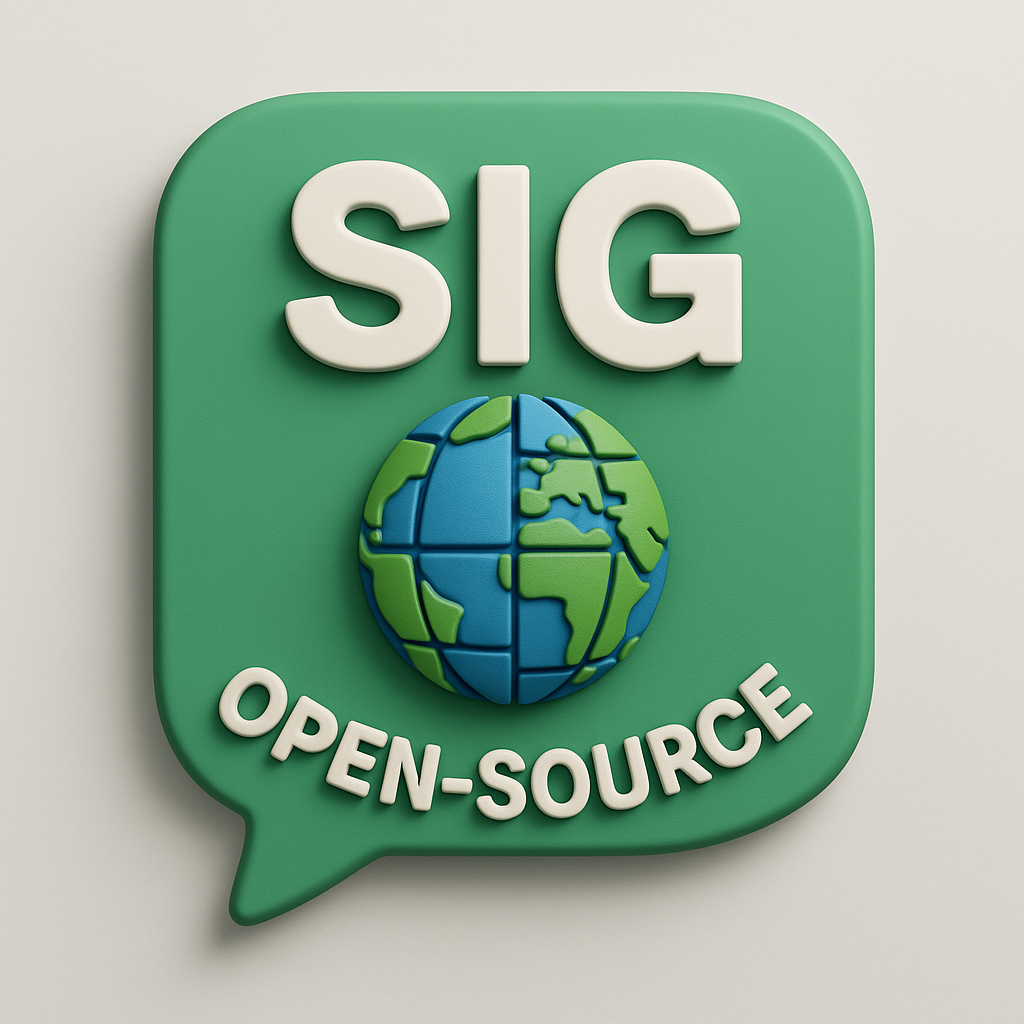

In [2]:
# %matplotlib widget
import pandas as pd
import numpy as np
import folium
from folium.plugins import MarkerCluster
from IPython.display import display, HTML, FileLink, clear_output, Image
import ipywidgets as widgets
import geopandas as gpd
from shapely.geometry import Point
import base64
import tempfile
import os
from io import BytesIO, StringIO
import zipfile
import re
import json

# Importation de la police Montserrat via Google Fonts et définition des styles CSS
css_style = """
<style>
    @import url('https://fonts.googleapis.com/css2?family=Montserrat:wght@400;500;700&display=swap');
    body {
        font-family: 'Montserrat', sans-serif;
    }
    .widget-label {
        min-width: 120px;
        max-width: 200px;
        font-weight: 500;
        color: #333;
        font-family: 'Montserrat', sans-serif;
        font-size: 14px;
    }
    .tab-content {
        padding: 15px;
        border: 1px solid #ddd;
        border-top: none;
        border-radius: 0 0 5px 5px;
    }
    .panel {
        padding: 15px;
        margin-bottom: 15px;
        border: 1px solid #e0e0e0;
        border-radius: 5px;
        background-color: #f9f9f9;
    }
    .panel-title {
        background-color: #4a86e8;
        color: white;
        padding: 8px 15px;
        margin: -15px -15px 15px -15px;
        border-radius: 5px 5px 0 0;
        font-weight: 700;
        font-family: 'Montserrat', sans-serif;
        font-size: 18px;
    }
    .success-msg {
        color: #28a745;
        font-weight: 500;
        font-family: 'Montserrat', sans-serif;
        font-size: 14px;
    }
    .error-msg {
        color: #dc3545;
        font-weight: 500;
        font-family: 'Montserrat', sans-serif;
        font-size: 14px;
    }
    .info-box {
        background-color: #e8f4f8;
        border-left: 5px solid #4a86e8;
        padding: 10px;
        margin: 10px 0;
        font-family: 'Montserrat', sans-serif;
        font-size: 14px;
    }
    .info-box h4 {
        font-weight: 700;
        font-size: 16px;
        margin-bottom: 8px;
    }
    .header-title {
        font-family: 'Montserrat', sans-serif;
        font-weight: 700;
        font-size: 32px;
        margin: 0;
        letter-spacing: 1px;
    }
    .header-subtitle {
        font-family: 'Montserrat', sans-serif;
        font-weight: 400;
        font-size: 18px;
        margin: 5px 0 0 0;
    }
    button, .btn, .btn-primary, .btn-success, .btn-danger {
        font-family: 'Montserrat', sans-serif;
        font-weight: 500;
        font-size: 14px;
    }
</style>
"""

display(HTML(css_style))

# Fonction pour convertir DD en DMS
def dd_to_dms(dd):
    dd = float(dd)
    is_negative = dd < 0
    dd = abs(dd)
    degrees = int(dd)
    minutes_float = (dd - degrees) * 60
    minutes = int(minutes_float)
    seconds = (minutes_float - minutes) * 60
    direction = 'S' if is_negative and dd <= 90 else 'W' if is_negative else 'N' if dd <= 90 else 'E'
    return f"{degrees}°{minutes}'{seconds:.2f}\"{direction}"

# Fonction pour convertir DMS en DD
def dms_to_dd(degrees, minutes, seconds, direction):
    dd = float(degrees) + float(minutes)/60 + float(seconds)/3600
    if direction in ['S', 'W', 's', 'w']:
        dd *= -1
    return dd

# Fonction pour parser une chaîne DMS
def parse_dms(dms_str):
    if isinstance(dms_str, (float, int)):
        return float(dms_str)
        
    pattern1 = r'(\d+)°(\d+)\'(\d+\.?\d*)\"([NSEW])'
    pattern2 = r'(\d+)°\s*(\d+)\'\s*(\d+\.?\d*)\"\s*([NSEW])'
    pattern3 = r'(\d+)\s+(\d+)\s+(\d+\.?\d*)\s+([NSEW])'
    
    for pattern in [pattern1, pattern2, pattern3]:
        match = re.match(pattern, str(dms_str).strip())
        if match:
            degrees, minutes, seconds, direction = match.groups()
            return dms_to_dd(degrees, minutes, seconds, direction)
    
    return None

# Classe pour gérer les données de coordonnées
class GeoDataManager:
    def __init__(self):
        self._data = pd.DataFrame(columns=['nom', 'latitude_dd', 'longitude_dd'])
        self.display_format = 'DD'
    
    def add_point_dd(self, name, lat, lon):
        new_data = pd.DataFrame({
            'nom': [name],
            'latitude_dd': [lat],
            'longitude_dd': [lon]
        })
        self._data = pd.concat([self._data, new_data], ignore_index=True)
        return f"<span class='success-msg'>Point '{name}' ajouté avec succès !</span>"
    
    def add_point_dms(self, name, lat_dms, lon_dms):
        try:
            lat_dd = parse_dms(lat_dms)
            lon_dd = parse_dms(lon_dms)
            
            if lat_dd is not None and lon_dd is not None:
                return self.add_point_dd(name, lat_dd, lon_dd)
            else:
                return "<span class='error-msg'>Erreur de conversion DMS</span>"
        except Exception as e:
            return f"<span class='error-msg'>Erreur lors de la conversion: {e}</span>"
    
    def import_csv_dd(self, df, name_col, lat_col, lon_col):
        try:
            final_df = pd.DataFrame({
                'nom': df[name_col],
                'latitude_dd': pd.to_numeric(df[lat_col], errors='coerce'),
                'longitude_dd': pd.to_numeric(df[lon_col], errors='coerce')
            })
            final_df = final_df.dropna()
            self._data = pd.concat([self._data, final_df], ignore_index=True)
            return f"<span class='success-msg'>{len(final_df)} points importés avec succès !</span>"
        except Exception as e:
            return f"<span class='error-msg'>Erreur lors de l'importation: {e}</span>"
    
    def import_csv_dms(self, df, name_col, lat_col, lon_col):
        try:
            lat_dd = []
            lon_dd = []
            
            for i, row in df.iterrows():
                try:
                    lat = parse_dms(str(row[lat_col]))
                    lon = parse_dms(str(row[lon_col]))
                    
                    if lat is None or lon is None:
                        print(f"Ligne {i+1}: Erreur de conversion DMS pour {row[lat_col]} ou {row[lon_col]}")
                        lat = np.nan
                        lon = np.nan
                    
                    lat_dd.append(lat)
                    lon_dd.append(lon)
                except Exception as e:
                    print(f"Erreur à la ligne {i+1}: {e}")
                    lat_dd.append(np.nan)
                    lon_dd.append(np.nan)
            
            final_df = pd.DataFrame({
                'nom': df[name_col],
                'latitude_dd': lat_dd,
                'longitude_dd': lon_dd
            })
            
            final_df = final_df.dropna()
            self._data = pd.concat([self._data, final_df], ignore_index=True)
            return f"<span class='success-msg'>{len(final_df)} points importés et convertis avec succès !</span>"
        except Exception as e:
            return f"<span class='error-msg'>Erreur lors de l'importation: {e}</span>"
    
    def clear_data(self):
        self._data = pd.DataFrame(columns=['nom', 'latitude_dd', 'longitude_dd'])
        return "<span class='success-msg'>Toutes les données ont été effacées !</span>"
    
    def set_display_format(self, format_type):
        if format_type in ['DD', 'DMS']:
            self.display_format = format_type
            return f"<span class='success-msg'>Format d'affichage changé en {format_type} !</span>"
        return "<span class='error-msg'>Format non reconnu</span>"
    
    def get_data_display(self):
        if self._data.empty:
            return pd.DataFrame(columns=['nom', 'latitude', 'longitude'])
            
        display_df = self._data.copy()
        
        if self.display_format == 'DD':
            display_df = display_df.rename(columns={
                'latitude_dd': 'latitude',
                'longitude_dd': 'longitude'
            })
        else:
            display_df['latitude'] = display_df['latitude_dd'].apply(dd_to_dms)
            display_df['longitude'] = display_df['longitude_dd'].apply(dd_to_dms)
        
        return display_df[['nom', 'latitude', 'longitude']]
    
    @property
    def data(self):
        return self.get_data_display()
    
    def create_map(self):
        if self._data.empty:
            return None
        
        m = folium.Map(
            location=[self._data['latitude_dd'].mean(), self._data['longitude_dd'].mean()], 
            zoom_start=10,
            tiles='CartoDB positron'
        )
        
        marker_cluster = MarkerCluster().add_to(m)
        
        for idx, row in self._data.iterrows():
            popup_text = f"""
            <div style='font-family: Montserrat, sans-serif;'>
                <h4 style='margin-bottom: 5px;'>{row['nom']}</h4>
                <b>Format DD:</b><br>
                Lat: {row['latitude_dd']:.6f}<br>
                Lon: {row['longitude_dd']:.6f}<br>
                <b>Format DMS:</b><br>
                Lat: {dd_to_dms(row['latitude_dd'])}<br>
                Lon: {dd_to_dms(row['longitude_dd'])}
            </div>
            """
            
            folium.Marker(
                location=[row['latitude_dd'], row['longitude_dd']],
                popup=folium.Popup(popup_text, max_width=300),
                tooltip=row['nom'],
                icon=folium.Icon(color='blue', icon='info-sign')
            ).add_to(marker_cluster)
        
        folium.LayerControl().add_to(m)
        
        return m
    
    def export_csv(self, filename="coordonnees.csv"):
        if self._data.empty:
            return "<span class='error-msg'>Aucune donnée à exporter</span>"
        
        self.get_data_display().to_csv(filename, index=False)
        return f"<span class='success-msg'>Données exportées dans {filename}</span>"
    
    def export_geojson(self, filename="coordonnees.geojson"):
        if self._data.empty:
            return "<span class='error-msg'>Aucune donnée à exporter</span>"
        
        gdf = gpd.GeoDataFrame(
            self._data, 
            geometry=gpd.points_from_xy(self._data['longitude_dd'], self._data['latitude_dd']),
            crs="EPSG:4326"
        )
        
        gdf['latitude_dms'] = gdf['latitude_dd'].apply(dd_to_dms)
        gdf['longitude_dms'] = gdf['longitude_dd'].apply(dd_to_dms)
        
        gdf.to_file(filename, driver='GeoJSON')
        return f"<span class='success-msg'>Données exportées dans {filename}</span>"
    
    def export_shapefile(self, filename="coordonnees"):
        if self._data.empty:
            return "<span class='error-msg'>Aucune donnée à exporter</span>"
        
        gdf = gpd.GeoDataFrame(
            self._data, 
            geometry=gpd.points_from_xy(self._data['longitude_dd'], self._data['latitude_dd']),
            crs="EPSG:4326"
        )
        
        gdf['lat_dms'] = gdf['latitude_dd'].apply(dd_to_dms)
        gdf['lon_dms'] = gdf['longitude_dd'].apply(dd_to_dms)
        
        zip_filename = f"{filename}.zip"
        with zipfile.ZipFile(zip_filename, 'w') as zipf:
            with tempfile.TemporaryDirectory() as temp_dir:
                temp_path = os.path.join(temp_dir, filename)
                gdf.to_file(temp_path, driver='ESRI Shapefile')
                for root, dirs, files in os.walk(temp_dir):
                    for file in files:
                        file_path = os.path.join(root, file)
                        arcname = os.path.relpath(file_path, temp_dir)
                        zipf.write(file_path, arcname=arcname)
        
        return f"<span class='success-msg'>Données exportées dans {zip_filename}</span>"

# Charger et convertir l'image en base64
def get_base64_image(image_path):
    try:
        with open(image_path, "rb") as image_file:
            return base64.b64encode(image_file.read()).decode('utf-8')
    except Exception as e:
        print(f"Erreur lors du chargement du logo: {e}")
        return ""

logo_path = r"C:\Users\UltraBook 3.1\Desktop\Convert\Logo.png"
logo_base64 = get_base64_image(logo_path)

html_title = HTML(f"""
<div style='background-color: #E0DDD6; color: #000000; padding: 15px; border-radius: 5px; margin-bottom: 20px; display: flex; align-items: center;'>
    <img src='data:image/png;base64,{logo_base64}' style='height: 50px; margin-right: 15px;' alt='Logo'>
    <div>
        <h1 class='header-title'>SIG Open-Source Coordinate Converter</h1>
        <h3 class='header-subtitle'>Outil de conversion et visualisation de coordonnées géographiques</h3>
    </div>
</div>
""")

display(html_title)

# Créer l'instance du gestionnaire de données
geo_manager = GeoDataManager()

# Onglets principaux
tabs = widgets.Tab(layout=widgets.Layout(width='100%'))
tab1 = widgets.VBox()
tab2 = widgets.VBox()

tabs.children = [tab1, tab2]
tabs.set_title(0, "Saisie de données")
tabs.set_title(1, "Visualisation et export")

# ----- Onglet 1: Saisie de données -----
input_method = widgets.RadioButtons(
    options=['Saisie manuelle', 'Import CSV'],
    description='Méthode:',
    disabled=False,
    layout=widgets.Layout(margin='10px 0')
)

# Saisie manuelle - DD
dd_title = widgets.HTML(value="<div class='panel-title'>Format Degrés Décimaux | DD</div>")
dd_panel = widgets.VBox(layout=widgets.Layout(
    border='1px solid #e0e0e0',
    margin='10px 0',
    padding='0',
    border_radius='5px'
))

point_name_dd = widgets.Text(
    value='Point 1',
    description='Nom:',
    disabled=False,
    layout=widgets.Layout(width='100%')
)
latitude_dd = widgets.FloatText(
    value=48.8566,
    description='Latitude:',
    disabled=False,
    layout=widgets.Layout(width='100%')
)
longitude_dd = widgets.FloatText(
    value=2.3522,
    description='Longitude:',
    disabled=False,
    layout=widgets.Layout(width='100%')
)
add_dd_button = widgets.Button(
    description='Ajouter le point (DD)',
    disabled=False,
    button_style='primary',
    icon='plus'
)
dd_output = widgets.Output()

dd_fields = widgets.VBox([point_name_dd, latitude_dd, longitude_dd, add_dd_button, dd_output], 
                         layout=widgets.Layout(padding='15px'))
dd_panel.children = [dd_title, dd_fields]

# Saisie manuelle - DMS
dms_title = widgets.HTML(value="<div class='panel-title'>Format Degrés Minutes Secondes | DMS</div>")
dms_panel = widgets.VBox(layout=widgets.Layout(
    border='1px solid #e0e0e0',
    margin='10px 0',
    padding='0',
    border_radius='5px'
))

point_name_dms = widgets.Text(
    value='Point DMS',
    description='Nom:',
    disabled=False,
    layout=widgets.Layout(width='100%')
)
latitude_dms = widgets.Text(
    value="48°51'23.81\"N",
    description='Latitude:',
    disabled=False,
    layout=widgets.Layout(width='100%')
)
longitude_dms = widgets.Text(
    value="2°21'7.999\"E",
    description='Longitude:',
    disabled=False,
    layout=widgets.Layout(width='100%')
)
add_dms_button = widgets.Button(
    description='Ajouter le point (DMS)',
    disabled=False,
    button_style='primary',
    icon='plus'
)
dms_output = widgets.Output()

dms_fields = widgets.VBox([point_name_dms, latitude_dms, longitude_dms, add_dms_button, dms_output], 
                          layout=widgets.Layout(padding='15px'))
dms_panel.children = [dms_title, dms_fields]

# Import CSV avec widget d'upload
csv_title = widgets.HTML(value="<div class='panel-title'>Import CSV</div>")
csv_panel = widgets.VBox(layout=widgets.Layout(
    border='1px solid #e0e0e0',
    margin='10px 0',
    padding='0',
    border_radius='5px'
))

file_upload = widgets.FileUpload(
    accept='.csv',
    multiple=False,
    description='Choisir CSV:',
    layout=widgets.Layout(width='auto')
)
file_preview = widgets.Output(layout=widgets.Layout(padding='10px', max_height='300px', overflow='auto'))
coord_type = widgets.RadioButtons(
    options=['Degrés Décimaux | DD', 'Degrés Minutes Secondes | DMS'],
    description='Format:',
    disabled=False
)

columns_box = widgets.VBox()
columns_output = widgets.Output()

csv_fields = widgets.VBox([
    widgets.HTML(value="<div class='info-box'>Importez un fichier CSV avec séparateur point-virgule (;) contenant des colonnes pour le nom du point et ses coordonnées.</div>"),
    file_upload, 
    coord_type, 
    file_preview, 
    columns_output
], layout=widgets.Layout(padding='15px'))
csv_panel.children = [csv_title, csv_fields]

# Table de données
data_title = widgets.HTML(value="<div class='panel-title'>Données actuelles</div>")
data_panel = widgets.VBox(layout=widgets.Layout(
    border='1px solid #e0e0e0',
    margin='10px 0',
    padding='0',
    border_radius='5px'
))

data_output = widgets.Output(layout=widgets.Layout(padding='10px', max_height='500px', overflow='auto'))
clear_button = widgets.Button(
    description='Effacer toutes les données',
    disabled=False,
    button_style='danger',
    icon='trash'
)
clear_output = widgets.Output()

convert_title = widgets.HTML(value="<h4 style='margin-top:20px; font-family: Montserrat, sans-serif; font-weight: 700;'>Changer le format d'affichage</h4>")
convert_format = widgets.RadioButtons(
    options=['DD', 'DMS'],
    value='DD',
    description='Format:',
    disabled=False
)
convert_button = widgets.Button(
    description='Changer le format',
    disabled=False,
    button_style='success',
    icon='refresh'
)
convert_output = widgets.Output()

convert_box = widgets.VBox([convert_title, convert_format, convert_button, convert_output])
buttons_box = widgets.HBox([clear_button, widgets.VBox([clear_output])], 
                          layout=widgets.Layout(align_items='flex-start'))

data_fields = widgets.VBox([data_output, buttons_box, convert_box], 
                          layout=widgets.Layout(padding='15px'))
data_panel.children = [data_title, data_fields]

# Fonction pour afficher la table de données courante
def show_current_data():
    with data_output:
        data_output.clear_output()
        if geo_manager._data.empty:
            display(HTML("<div class='info-box'>Aucune donnée disponible</div>"))
        else:
            display(HTML("<h4 style='font-family: Montserrat, sans-serif; font-weight: 700;'>Format d'affichage actuel: " + geo_manager.display_format + "</h4>"))
            display(geo_manager.get_data_display().style.set_table_attributes('class="table table-striped table-hover"'))

# Événements des boutons
def on_add_dd_clicked(b):
    with dd_output:
        dd_output.clear_output()
        result = geo_manager.add_point_dd(
            point_name_dd.value,
            latitude_dd.value,
            longitude_dd.value
        )
        display(HTML(result))
        show_current_data()

def on_add_dms_clicked(b):
    with dms_output:
        dms_output.clear_output()
        result = geo_manager.add_point_dms(
            point_name_dms.value,
            latitude_dms.value,
            longitude_dms.value
        )
        display(HTML(result))
        show_current_data()

def on_clear_clicked(b):
    with clear_output:
        clear_output.clear_output()
        result = geo_manager.clear_data()
        display(HTML(result))
        show_current_data()
        with file_preview:
            file_preview.clear_output()

def on_convert_clicked(b):
    with convert_output:
        convert_output.clear_output()
        result = geo_manager.set_display_format(convert_format.value)
        display(HTML(result))
        show_current_data()
        update_map()

add_dd_button.on_click(on_add_dd_clicked)
add_dms_button.on_click(on_add_dms_clicked)
clear_button.on_click(on_clear_clicked)
convert_button.on_click(on_convert_clicked)

# Fonction pour gérer l'upload de fichier CSV
def on_file_upload_change(change):
    if not file_upload.value:
        return
    
    with file_preview:
        file_preview.clear_output()
        
        try:
            uploaded_file = list(file_upload.value.values())[0]
            filename = uploaded_file['metadata']['name']
            content = uploaded_file['content']
            
            content_bytes = bytes(content)
            encodings = ['utf-8', 'latin-1', 'windows-1252']
            content_str = None
            for encoding in encodings:
                try:
                    content_str = content_bytes.decode(encoding)
                    display(HTML(f"<div class='success-msg'>Fichier décodé avec succès en utilisant {encoding}</div>"))
                    break
                except UnicodeDecodeError:
                    continue
            
            if content_str is None:
                raise UnicodeDecodeError("Impossible de décoder le fichier avec les encodages UTF-8, Latin-1 ou Windows-1252")
            
            string_io = StringIO(content_str)
            try:
                df = pd.read_csv(string_io, sep=';')
            except:
                display(HTML("<div class='error-msg'>Erreur de lecture du CSV. Assurez-vous que le séparateur est un point-virgule (;)</div>"))
                return
            
            display(HTML(f"<div class='panel-title'>Aperçu du fichier CSV ({len(df)} lignes, {len(df.columns)} colonnes)</div>"))
            display(df.head().style.set_table_attributes('class="table table-striped table-hover"'))
            
            with columns_output:
                columns_output.clear_output()
                
                col_options = list(df.columns)
                name_col_dropdown = widgets.Dropdown(
                    options=col_options,
                    value=col_options[0] if col_options else None,
                    description='Col. Nom:',
                    disabled=False,
                    layout=widgets.Layout(width='auto')
                )
                lat_col_dropdown = widgets.Dropdown(
                    options=col_options,
                    value=col_options[min(1, len(col_options)-1)] if len(col_options) > 1 else col_options[0] if col_options else None,
                    description='Col. Lat:',
                    disabled=False,
                    layout=widgets.Layout(width='auto')
                )
                lon_col_dropdown = widgets.Dropdown(
                    options=col_options,
                    value=col_options[min(2, len(col_options)-1)] if len(col_options) > 2 else col_options[0] if col_options else None,
                    description='Col. Lon:',
                    disabled=False,
                    layout=widgets.Layout(width='auto')
                )
                
                import_button = widgets.Button(
                    description='Importer',
                    disabled=False,
                    button_style='primary',
                    icon='upload'
                )
                
                import_output = widgets.Output()
                
                def on_import_clicked(b):
                    with import_output:
                        import_output.clear_output()
                        try:
                            string_io = StringIO(content_str)
                            df = pd.read_csv(string_io, sep=';')
                            
                            sample_lat = str(df[lat_col_dropdown.value].iloc[0])
                            sample_lon = str(df[lon_col_dropdown.value].iloc[0])
                            selected_format = coord_type.value
                            
                            display(HTML("<div class='info-box'>Analyse des données...</div>"))
                            
                            if 'DD' in selected_format:
                                try:
                                    float(sample_lat)
                                    float(sample_lon)
                                except ValueError:
                                    display(HTML("<div class='error-msg'>Erreur : Les données semblent être en DMS ou un format invalide, mais DD est sélectionné.</div>"))
                                    return
                            
                            if 'DD' in selected_format:
                                result = geo_manager.import_csv_dd(
                                    df,
                                    name_col_dropdown.value,
                                    lat_col_dropdown.value,
                                    lon_col_dropdown.value
                                )
                                display(HTML(result))
                            else:
                                result = geo_manager.import_csv_dms(
                                    df,
                                    name_col_dropdown.value,
                                    lat_col_dropdown.value,
                                    lon_col_dropdown.value
                                )
                                display(HTML(result))
                            show_current_data()
                            update_map()
                        except Exception as e:
                            display(HTML(f"<div class='error-msg'>Erreur lors de l'importation: {e}</div>"))
                
                import_button.on_click(on_import_clicked)
                
                display(widgets.VBox([
                    widgets.HTML(value="<h4 style='font-family: Montserrat, sans-serif; font-weight: 700;'>Sélection des colonnes</h4>"),
                    name_col_dropdown,
                    lat_col_dropdown,
                    lon_col_dropdown,
                    import_button,
                    import_output
                ]))
        except Exception as e:
            display(HTML(f"<div class='error-msg'>Erreur lors du traitement du fichier: {e}</div>"))
            import traceback
            traceback.print_exc()

file_upload.observe(on_file_upload_change, names='value')

# Organisation de l'onglet 1
manual_input = widgets.HBox([dd_panel, dms_panel], layout=widgets.Layout(width='100%'))

def update_input_method(change):
    if change['new'] == 'Saisie manuelle':
        tab1.children = [input_method, manual_input, data_panel]
    else:
        tab1.children = [input_method, csv_panel, data_panel]

input_method.observe(update_input_method, names='value')
tab1.children = [input_method, manual_input, data_panel]

# ----- Onglet 2: Visualisation et export -----
map_title = widgets.HTML(value="<div class='panel-title'>Carte interactive</div>")
map_panel = widgets.VBox(layout=widgets.Layout(
    border='1px solid #e0e0e0',
    margin='10px 0',
    padding='0',
    border_radius='5px'
))

map_output = widgets.Output(layout=widgets.Layout(height='500px', border='1px solid #ddd'))

export_title = widgets.HTML(value="<div class='panel-title'>Exporter les données</div>")
export_panel = widgets.VBox(layout=widgets.Layout(
    border='1px solid #e0e0e0',
    margin='10px 0',
    padding='0',
    border_radius='5px'
))

export_format = widgets.Dropdown(
    options=['CSV', 'GeoJSON', 'SHP'],
    value='CSV',
    description='Format fichier:',
    layout=widgets.Layout(width='auto')
)
export_button = widgets.Button(
    description='Exporter',
    disabled=False,
    button_style='success',
    icon='download'
)
export_output = widgets.Output()

export_fields = widgets.VBox([
    widgets.HTML(value="<div class='info-box'>Exportez vos données dans différents formats pour les utiliser dans d'autres logiciels SIG.</div>"),
    export_format, 
    export_button, 
    export_output
], layout=widgets.Layout(padding='15px'))

export_panel.children = [export_title, export_fields]
map_fields = widgets.VBox([map_output], layout=widgets.Layout(padding='15px'))
map_panel.children = [map_title, map_fields]

# Organisation de l'onglet 2
tab2.children = [map_panel, export_panel]

# Fonction pour mettre à jour la carte
def update_map():
    with map_output:
        map_output.clear_output()
        if geo_manager._data.empty:
            display(HTML("<div class='info-box'>Aucune donnée à afficher sur la carte. Veuillez ajouter des points.</div>"))
        else:
            m = geo_manager.create_map()
            if m:
                display(m)

# Événement du bouton d'export
def on_export_clicked(b):
    with export_output:
        export_output.clear_output()
        if geo_manager._data.empty:
            display(HTML("<div class='error-msg'>Aucune donnée à exporter</div>"))
            return
        
        try:
            if export_format.value == 'CSV':
                result = geo_manager.export_csv()
                if "success" in result:
                    display(FileLink('coordonnees.csv'))
            elif export_format.value == 'GeoJSON':
                result = geo_manager.export_geojson()
                if "success" in result:
                    display(FileLink('coordonnees.geojson'))
            elif export_format.value == 'SHP':
                result = geo_manager.export_shapefile()
                if "success" in result:
                    display(FileLink('coordonnees.zip'))
            
            display(HTML(result))
        except Exception as e:
            display(HTML(f"<div class='error-msg'>Erreur lors de l'exportation: {e}</div>"))

export_button.on_click(on_export_clicked)

# Afficher l'interface
display(tabs)
update_map()
show_current_data()

# Ajouter un message de bienvenue
welcome_html = HTML("""
<div class='info-box' style='margin-top: 20px;'>
    <h4>Bienvenue dans SIG Open-Source Coordinate Converter</h4>
    <p>Cette application vous permet de:</p>
    <ul>
        <li>Saisir des coordonnées géographiques en format DD ou DMS</li>
        <li>Importer des données depuis un fichier CSV</li>
        <li>Visualiser vos points sur une carte interactive</li>
        <li>Exporter vos données dans différents formats SIG</li>
    </ul>
    <p>Commencez par ajouter des points ou importer un fichier CSV.</p>
</div>
""")

display(welcome_html)

# Aide au format DMS
help_dms = HTML("""
<div class='info-box' style='margin-top: 10px;'>
    <h4>Formats DMS acceptés:</h4>
    <ul>
        <li>48°51'23.81"N (standard)</li>
        <li>48° 51' 23.81" N (avec espaces)</li>
        <li>48 51 23.81 N (sans symboles)</li>
    </ul>
</div>
""")

display(help_dms)